In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-bangladeshi-crop-disease/Info.txt
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust762.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust777.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust1024.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust811.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust617.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_rust251.jpg
/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat/Wheat___Yellow_Rust/Yellow_

# Load Dataset

In [2]:
directory = '../input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease'

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
print(os.listdir(directory))

['Wheat', 'Corn', 'Rice', 'Potato']


In [5]:
potato_dir = '../input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Potato'

# Import Library

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import splitfolders
import seaborn as sns
import tensorflow as tf
import tensorflow 
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, MaxPool2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

2024-06-13 01:50:45.545000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 01:50:45.545106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 01:50:45.658099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
potato = image_dataset_from_directory(potato_dir,
                                       shuffle=True,
                                       label_mode = 'categorical',
                                       batch_size=BATCH_SIZE,
                                       seed = 42,
                                       image_size=IMG_SIZE)

Found 2152 files belonging to 3 classes.


In [8]:
category = ['Potato Early Blight','Potato Healthy','Potato Late Blight']
count = [1000, 152, 1000]

In [9]:
crop_df = pd.DataFrame({'Category': ['Potato Early Blight','Potato Healthy','Potato Late Blight'], 'total_images': [1000, 152, 1000]})
crop_df.set_index('Category', inplace=True)
crop_df

,total_images
Category,
Potato Early Blight,1000
Potato Healthy,152
Potato Late Blight,1000


<Axes: title={'center': 'Image Distribution for Class Labels'}, ylabel='total_images'>

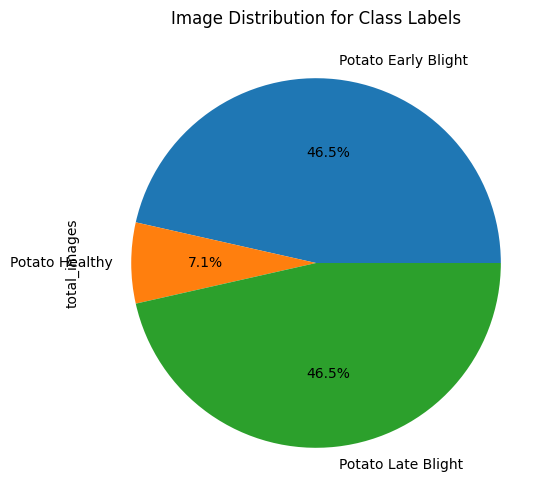

In [10]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
crop_df.total_images.plot(kind='pie', ax=ax, startangle=0, fontsize=10, autopct='%1.1f%%', title='Image Distribution for Class Labels')

In [11]:
input_folder = potato_dir
output_folder = '/kaggle/working/potato'

# Modelling

## Splitting dataset image and preparing ImageDataGenerator

In [12]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.20, 0.10))

Copying files: 2152 files [00:08, 268.74 files/s]


In [13]:
train_dir = "/kaggle/working/potato/train"
test_dir = "/kaggle/working/potato/test"
val_dir = "/kaggle/working/potato/val"
generator_train = ImageDataGenerator(rescale=1./255, height_shift_range=0.1,
                                     horizontal_flip=True, vertical_flip=False)
generator_test = ImageDataGenerator(rescale=1./255, height_shift_range=0.1,
                                     horizontal_flip=True, vertical_flip=False)
generator_val = ImageDataGenerator(rescale=1./255)
train_ds = generator_train.flow_from_directory(
    train_dir, target_size=(64,64), 
    batch_size=32, class_mode="categorical", 
    color_mode="rgb"
)
test_ds = generator_test.flow_from_directory(
    test_dir, target_size=(64,64), 
    batch_size=32, class_mode="categorical", 
    color_mode="rgb"
)
val_ds = generator_val.flow_from_directory(
    val_dir, target_size=(64,64), 
    batch_size=32, class_mode="categorical", 
    color_mode="rgb"
)

Found 1506 images belonging to 3 classes.
Found 216 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [14]:
train_ds

# ML Model

In [15]:
model = Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

hist = model.fit(train_ds, batch_size=5, epochs=100, validation_split=5, validation_data=test_ds)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 4/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4772 - loss: 7.9330

I0000 00:00:1718243474.202695     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.4668 - loss: 5.6733 - val_accuracy: 0.4630 - val_loss: 1.7707
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5984 - loss: 1.4433 - val_accuracy: 0.7778 - val_loss: 0.8695
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7943 - loss: 0.7714 - val_accuracy: 0.8056 - val_loss: 0.6320
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8396 - loss: 0.6128 - val_accuracy: 0.8657 - val_loss: 0.5261
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8696 - loss: 0.5169 - val_accuracy: 0.8704 - val_loss: 0.5499
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8853 - loss: 0.5287 - val_accuracy: 0.9167 - val_loss: 0.4066
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9145 - loss: 0.4118 - val_accuracy: 0.8148 - val_loss: 0.5694
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8682 - loss: 0.5741 - val_accuracy: 0.9259 - val

In [16]:
print('MODEL ACCURACY = {}%'.format(hist.history["accuracy"][-1]*100))
print('VALIDATION ACCURACY = {}%'.format(hist.history["val_accuracy"][-1]*100))

MODEL ACCURACY = 93.02788972854614%
VALIDATION ACCURACY = 92.59259104728699%


# Plot Model Curve and Confusion Matrix

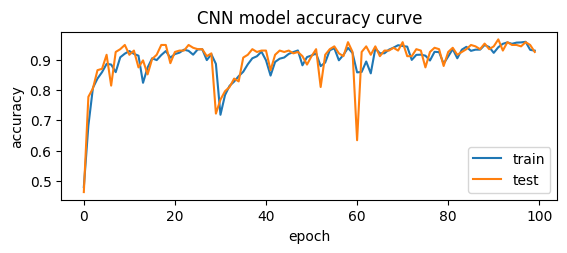

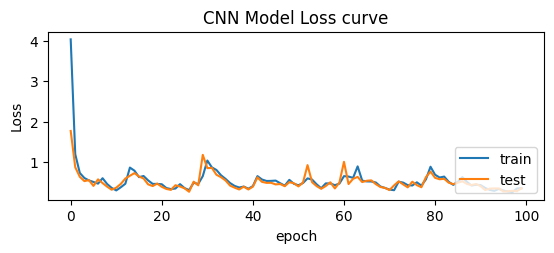

In [17]:
plt.subplot(2,1,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('CNN model accuracy curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Model Loss curve')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Confusion matrix:



<Axes: >

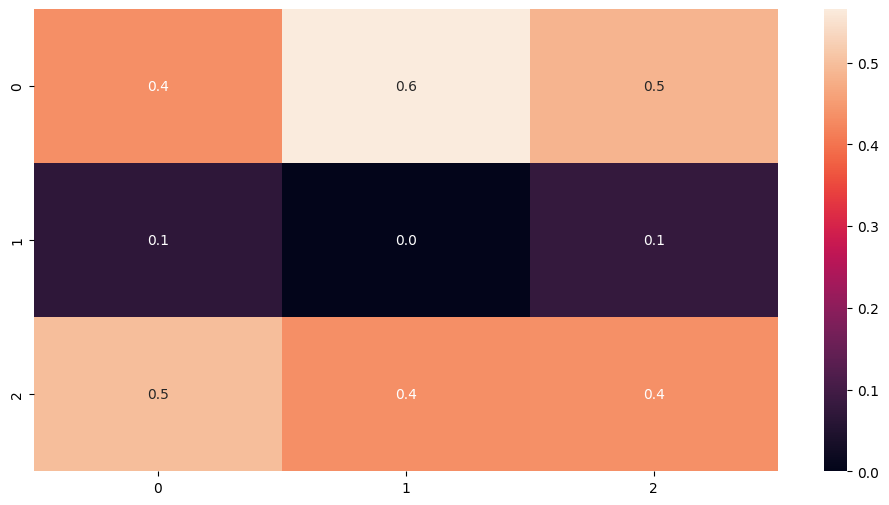

In [18]:
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(val_ds.classes, y_pred_classes, normalize='pred')

print('Confusion matrix:\n')
plt.figure(figsize=(12,6))
sns.heatmap(conf_mat, annot=True, fmt=".1f")

In [20]:
score = model.evaluate(test_ds, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9160 - loss: 0.3873
Test loss: 0.36016878485679626 / Test accuracy: 0.9305555820465088


## Test model

In [33]:
import numpy as np
from keras.preprocessing import image

image_path = '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Potato/Potato___Early_Blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'  

def load_and_process_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

processed_image = load_and_process_image(image_path)
predictions = model.predict(processed_image)

class_names = {
    0: "Potato___Early_Blight",
    1: "Potato___Healthy",
    2: "Potato___Late_Blight"
}

predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]

print("Result Prediction:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result Prediction: Potato___Early_Blight


## Save Model 

In [34]:
saved_model_path = './potato_leafdisease_prediction_model.h5'
model.save(saved_model_path)